# 기본 증강 코드

In [5]:
# ===== 셀 0: 경로/타깃/컬럼 설정 =====
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로
INPUT_CSV = '/content/drive/MyDrive/404DNF/data/merged_data.csv'
OUTPUT_DIR = '/content/drive/MyDrive/404DNF/outputs'

import os, pandas as pd, numpy as np
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
rng = np.random.default_rng(SEED)

# 컬럼명(현재 데이터 스키마에 맞춤)
TEXT_COL  = 'String'  # 문장
TYPE_COL  = 'Type'    # 다중 클래스 라벨
BIN_COL   = 'label'   # 0/1

# 목표치 — 5개 클래스만 사용
TARGETS = {
    'Not Dark Pattern': 1000,   # Under
    'Scarcity': 500,            # Under
    'Social Proof': 500,        # Under
    'Urgency': 500,             # Over
    'Misdirection': 500,        # Over
}
labels_under = ['Not Dark Pattern', 'Scarcity', 'Social Proof']
labels_over  = ['Urgency', 'Misdirection']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# ===== 셀 1: 데이터 로드 & 5클래스 필터 =====
df = pd.read_csv(INPUT_CSV)
assert set([TEXT_COL, TYPE_COL, BIN_COL]).issubset(df.columns), "필수 컬럼 누락(String/Type/label)"

# 5개 타깃 클래스만 사용(기타 클래스 제거)
df = df[df[TYPE_COL].isin(TARGETS.keys())].copy()

print("원본(필터 후) 라벨 분포:")
print(df[TYPE_COL].value_counts().sort_index())

원본(필터 후) 라벨 분포:
Type
Misdirection         432
Not Dark Pattern    1178
Scarcity            1096
Social Proof         626
Urgency              447
Name: count, dtype: int64


In [7]:
# ===== 셀 2: 언더샘플 베이스(전체 df 기준) =====
def undersample_group(g: pd.DataFrame, k: int) -> pd.DataFrame:
    if len(g) <= k:
        return g.sample(n=len(g), random_state=SEED)
    return g.sample(n=k, random_state=SEED)

parts = []
# 언더 대상 → 목표치로 다운샘플
for lab in labels_under:
    sub = df[df[TYPE_COL] == lab]
    us = undersample_group(sub, TARGETS[lab])
    parts.append(us)

# 오버 대상 → 언더 단계에선 원본 그대로
for lab in labels_over:
    parts.append(df[df[TYPE_COL] == lab])

df_under_base = pd.concat(parts, ignore_index=True)

print("언더샘플 베이스 분포:")
print(df_under_base[TYPE_COL].value_counts().sort_index())

# 참고용 저장(옵션)
df_under_base[[TEXT_COL, TYPE_COL, BIN_COL]].to_csv(
    os.path.join(OUTPUT_DIR, 'balanced_base_before_over.csv'), index=False, encoding='utf-8'
)

언더샘플 베이스 분포:
Type
Misdirection         432
Not Dark Pattern    1000
Scarcity             500
Social Proof         500
Urgency              447
Name: count, dtype: int64


In [8]:
# ===== 셀 3: 부족량 계산 & 최종 결합 유틸 (label 자동 보정 포함) =====
def get_need_counts(df_base: pd.DataFrame, labels_over: list, targets: dict) -> dict:
    need = {}
    for lab in labels_over:
        cur = int((df_base[TYPE_COL] == lab).sum())
        need[lab] = max(0, targets[lab] - cur)
    return need

def finalize_with_aug(df_base: pd.DataFrame, aug_df: pd.DataFrame, targets: dict) -> pd.DataFrame:
    """
    공통 베이스(df_base)에 증강(aug_df)을 합치고, 라벨별 상한(TARGETS)에 맞춘 뒤,
    마지막에 label을 자동 보정: Not Dark Pattern=0, 그 외=1
    """
    out = df_base.copy()
    if aug_df is not None and len(aug_df):
        out = pd.concat([out, aug_df], ignore_index=True)

    # 라벨별 상한 맞추기
    fixed = []
    for lab, t in targets.items():
        sub = out[out[TYPE_COL] == lab]
        if len(sub) > t:
            sub = sub.sample(n=t, random_state=SEED)
        fixed.append(sub)

    out2 = pd.concat(fixed, ignore_index=True)


    # === label 자동 보정 ===
    out2.loc[out2[TYPE_COL] == "Not Dark Pattern", BIN_COL] = 0
    out2.loc[out2[TYPE_COL] != "Not Dark Pattern", BIN_COL] = 1

    # (⭐ 추가) 정수형 고정
    out2[BIN_COL] = out2[BIN_COL].astype(int)

    # 유효 클래스만 유지 + 셔플
    out2 = out2[out2[TYPE_COL].isin(targets.keys())]
    out2 = out2.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    return out2[[TEXT_COL, TYPE_COL, BIN_COL]]

In [9]:
# ===== 셀 4: 템플릿 증강 =====
time_slots     = ["10 minutes", "15 minutes", "30 minutes", "1 hour", "3 hours", "today", "tonight", "24 hours"]
stock_slots    = ["2", "3", "5", "7", "10", "12", "20"]
discount_slots = ["10", "15", "20", "25", "30", "40", "50"]
fee_slots      = ["service fee", "processing fee", "handling fee", "membership fee"]
bonus_slots    = ["free gift", "bonus points", "extra coupon", "exclusive access"]

URGENCY_TEMPLATES = [
    "Only {time} left to claim your {discount}% discount!",
    "Hurry—just {stock} items remaining. Don’t miss out!",
    "Offer ends {time}! Secure your deal now.",
    "Final hours: {discount}% off ends {time}.",
    "Act fast! Only {stock} left in stock.",
    "Limited-time deal: {discount}% off if you buy within {time}.",
    "Sale ends {time}. This is your last chance!",
    "Countdown alert: {time} remaining to save {discount}%.",
]

MISDIRECTION_TEMPLATES = [
    "Continue to claim your {bonus} (auto-applies at checkout).",
    "Your {bonus} is ready—press 'Continue' to proceed.",
    "Best value pre-selected for you (change anytime).",
    "You’re almost done! Click ‘Next’ to get started.",
    "Recommended option selected (you can modify later).",
    "Processing will be faster with Express Checkout (selected).",
    "Your discount is applied.*  *Additional {fee} may appear at checkout.",
    "Almost there—confirm details to receive {bonus}.",
]

def render_template(tmpl: str) -> str:
    return tmpl.format(
        time=rng.choice(time_slots),
        stock=rng.choice(stock_slots),
        discount=rng.choice(discount_slots),
        fee=rng.choice(fee_slots),
        bonus=rng.choice(bonus_slots),
    )

def generate_by_templates(label: str, n: int) -> pd.DataFrame:
    rows = []
    base = URGENCY_TEMPLATES if label == 'Urgency' else MISDIRECTION_TEMPLATES
    for _ in range(n):
        text = render_template(rng.choice(base))
        rows.append({TEXT_COL: text, TYPE_COL: label, BIN_COL: 1})  # 합성은 다크패턴이므로 label=1
    return pd.DataFrame(rows, columns=[TEXT_COL, TYPE_COL, BIN_COL])

need_counts = get_need_counts(df_under_base, labels_over, TARGETS)
aug_list = []
for lab, need in need_counts.items():
    if need > 0:
        aug_list.append(generate_by_templates(lab, need))
df_aug_template = pd.concat(aug_list, ignore_index=True) if aug_list else pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])

df_template_final = finalize_with_aug(df_under_base, df_aug_template, TARGETS)
print("템플릿 균형 분포:")
print(df_template_final[TYPE_COL].value_counts().sort_index())

템플릿 균형 분포:
Type
Misdirection         500
Not Dark Pattern    1000
Scarcity             500
Social Proof         500
Urgency              500
Name: count, dtype: int64


In [10]:
# ===== 셀 5: 패러프레이즈 증강 =====
!pip -q install transformers sentencepiece accelerate
from transformers import pipeline

paraphraser = None
used_model, used_prompt = None, None
for model_name, prompt in [("tuner007/pegasus_paraphrase", None), ("t5-base", "paraphrase: {text} </s>")]:
    try:
        paraphraser = pipeline("text2text-generation", model=model_name, device_map="auto")
        used_model, used_prompt = model_name, prompt
        print("모델 로드 성공:", model_name)
        break
    except Exception as e:
        print("모델 로드 실패:", model_name, e)

assert paraphraser is not None, "패러프레이즈 모델 로드 실패"

def do_paraphrase(txt: str) -> str:
    inp = used_prompt.format(text=txt) if used_prompt else txt
    out = paraphraser(inp, max_length=64, num_return_sequences=1, do_sample=True, top_p=0.95, temperature=0.9)
    return out[0]['generated_text'].strip()

def build_paraphrase_aug(df_base: pd.DataFrame, label: str, n: int) -> pd.DataFrame:
    if n <= 0:
        return pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])
    src = df_base[df_base[TYPE_COL] == label][TEXT_COL].dropna().tolist()
    if not src:
        return pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])
    picked = rng.choice(src, size=n, replace=True)
    rows = []
    for s in picked:
        try:
            para = do_paraphrase(s)
        except Exception:
            para = s.replace("!", ".")
        rows.append({TEXT_COL: para, TYPE_COL: label, BIN_COL: 1})
    return pd.DataFrame(rows, columns=[TEXT_COL, TYPE_COL, BIN_COL])

need_counts = get_need_counts(df_under_base, labels_over, TARGETS)
aug_list = []
for lab, need in need_counts.items():
    if need > 0:
        aug_list.append(build_paraphrase_aug(df_under_base, lab, need))
df_aug_para = pd.concat(aug_list, ignore_index=True) if aug_list else pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])

df_para_final = finalize_with_aug(df_under_base, df_aug_para, TARGETS)
print("패러프레이즈 균형 분포:")
print(df_para_final[TYPE_COL].value_counts().sort_index())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cuda:0


모델 로드 성공: tuner007/pegasus_paraphrase


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (64 > 60). Running this sequence through the model will result in indexing errors


패러프레이즈 균형 분포:
Type
Misdirection         500
Not Dark Pattern    1000
Scarcity             500
Social Proof         500
Urgency              500
Name: count, dtype: int64


In [11]:
# ===== 셀 6: 컨텍스추얼(MLM) 증강 =====
!pip -q install transformers
from transformers import pipeline
import re

fill_mask = pipeline("fill-mask", model="bert-base-uncased", device_map="auto")
MASK = fill_mask.tokenizer.mask_token

TRIGGERS = {
    'Urgency': [
        r'\blimited time\b', r'\bending soon\b', r'\bonly today\b', r'\bact fast\b',
        r'\bhurry\b', r'\blast chance\b', r'\bfinal hours\b', r'\bjust \d+ (left|items)\b',
        r'\bcountdown\b', r'\boffer ends\b'
    ],
    'Misdirection': [
        r'\brecommended\b', r'\bbest value\b', r'\bcontinue\b', r'\bnext\b',
        r'\bpre-?selected\b', r'\bexpress checkout\b', r'\bbonus\b', r'\bapplied\b',
        r'\b(discount|fee)s?\b'
    ]
}

def mask_one_trigger(text: str, label: str) -> str:
    pats = TRIGGERS.get(label, [])
    hits = []
    for p in pats:
        for m in re.finditer(p, text, flags=re.IGNORECASE):
            hits.append((m.start(), m.end()))
    if not hits: return text
    start, end = hits[rng.integers(0, len(hits))]
    return text[:start] + MASK + text[end:]

def fill_mask_once(text: str) -> str:
    if MASK not in text: return text
    try:
        res = fill_mask(text, top_k=5)
        cand = res[0]['token_str'].strip()
        return text.replace(MASK, cand, 1)
    except Exception:
        return text

def build_mlm_aug(df_base: pd.DataFrame, label: str, n: int) -> pd.DataFrame:
    if n <= 0:
        return pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])
    src = df_base[df_base[TYPE_COL] == label][TEXT_COL].dropna().tolist()
    if not src:
        return pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])
    picked = rng.choice(src, size=n, replace=True)
    rows = []
    for s in picked:
        masked = mask_one_trigger(s, label)
        filled = fill_mask_once(masked)
        if filled.strip().lower() == s.strip().lower():
            filled = s.replace("!", ".")
        rows.append({TEXT_COL: filled, TYPE_COL: label, BIN_COL: 1})
    return pd.DataFrame(rows, columns=[TEXT_COL, TYPE_COL, BIN_COL])

need_counts = get_need_counts(df_under_base, labels_over, TARGETS)
aug_list = []
for lab, need in need_counts.items():
    if need > 0:
        aug_list.append(build_mlm_aug(df_under_base, lab, need))
df_aug_context = pd.concat(aug_list, ignore_index=True) if aug_list else pd.DataFrame(columns=[TEXT_COL, TYPE_COL, BIN_COL])

df_context_final = finalize_with_aug(df_under_base, df_aug_context, TARGETS)
print("컨텍스추얼 균형 분포:")
print(df_context_final[TYPE_COL].value_counts().sort_index())

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


컨텍스추얼 균형 분포:
Type
Misdirection         500
Not Dark Pattern    1000
Scarcity             500
Social Proof         500
Urgency              500
Name: count, dtype: int64


In [12]:
# ===== 셀 7: 최종 균형 세트 7:3 분할 저장 =====
from sklearn.model_selection import train_test_split

def split_and_save(df_final, name_prefix):
    train_df, test_df = train_test_split(
        df_final,
        test_size=0.3,
        random_state=SEED,
        stratify=df_final[TYPE_COL]
    )
    train_path = os.path.join(OUTPUT_DIR, f'{name_prefix}_train.csv')
    test_path  = os.path.join(OUTPUT_DIR, f'{name_prefix}_test.csv')
    train_df.to_csv(train_path, index=False, encoding='utf-8')
    test_df.to_csv(test_path, index=False, encoding='utf-8')
    print(f"\n[{name_prefix}] 저장 완료")
    print("Train 분포:\n", train_df[TYPE_COL].value_counts().sort_index())
    print("Test 분포:\n",  test_df[TYPE_COL].value_counts().sort_index())

# 각 증강 방식별 분할 저장
split_and_save(df_template_final,  "template")
split_and_save(df_para_final,      "paraphrase")
split_and_save(df_context_final,   "contextual")


[template] 저장 완료
Train 분포:
 Type
Misdirection        350
Not Dark Pattern    700
Scarcity            350
Social Proof        350
Urgency             350
Name: count, dtype: int64
Test 분포:
 Type
Misdirection        150
Not Dark Pattern    300
Scarcity            150
Social Proof        150
Urgency             150
Name: count, dtype: int64

[paraphrase] 저장 완료
Train 분포:
 Type
Misdirection        350
Not Dark Pattern    700
Scarcity            350
Social Proof        350
Urgency             350
Name: count, dtype: int64
Test 분포:
 Type
Misdirection        150
Not Dark Pattern    300
Scarcity            150
Social Proof        150
Urgency             150
Name: count, dtype: int64

[contextual] 저장 완료
Train 분포:
 Type
Misdirection        350
Not Dark Pattern    700
Scarcity            350
Social Proof        350
Urgency             350
Name: count, dtype: int64
Test 분포:
 Type
Misdirection        150
Not Dark Pattern    300
Scarcity            150
Social Proof        150
Urgency             150

In [13]:
# ===== 셀 8: 파일 존재/샘플 확인(옵션) =====
for name in [
    'template_train.csv','template_test.csv',
    'paraphrase_train.csv','paraphrase_test.csv',
    'contextual_train.csv','contextual_test.csv'
]:
    p = os.path.join(OUTPUT_DIR, name)
    if os.path.exists(p):
        tmp = pd.read_csv(p)
        print(f"\n=== {name} ===")
        print(tmp[TYPE_COL].value_counts().sort_index())
        print(tmp.head(3)[[TEXT_COL, TYPE_COL, BIN_COL]])


=== template_train.csv ===
Type
Misdirection        350
Not Dark Pattern    700
Scarcity            350
Social Proof        350
Urgency             350
Name: count, dtype: int64
                                              String              Type  label
0                               Perhaps you could...  Not Dark Pattern      0
1  Natalie in Graham, United States purchased a F...      Social Proof      1
2                     Real time 30 Visitor right now      Social Proof      1

=== template_test.csv ===
Type
Misdirection        150
Not Dark Pattern    300
Scarcity            150
Social Proof        150
Urgency             150
Name: count, dtype: int64
                                              String          Type  label
0  RECENTLY VIEWED 2 others viewed this in the la...  Social Proof      1
1                            72 Viewing This Product  Social Proof      1
2                             No, I don't feel lucky  Misdirection      1

=== paraphrase_train.csv ===
Type


# 검증 코드

In [20]:
import pandas as pd

df_orig = pd.read_csv("/content/drive/MyDrive/404DNF/data/merged_data.csv")

# 전체 행 수
total_rows = len(df_orig)

# 중복 행 수 (문장 기준)
dup_rows = df_orig.duplicated(subset=["String"]).sum()

print("전체 문장 수:", total_rows)
print("중복 문장 수:", dup_rows)
print("중복 비율:", dup_rows / total_rows)

전체 문장 수: 3868
중복 문장 수: 1512
중복 비율: 0.390899689762151


In [14]:
# ===== 검증 셀 0: 경로/임포트/대상 파일 지정 =====
import os, random, math
import pandas as pd
import numpy as np

# 드라이브 경로 맞게 수정
OUT_DIR = '/content/drive/MyDrive/404DNF/outputs'

FILES = [
    'template_train.csv', 'template_test.csv',
    'paraphrase_train.csv', 'paraphrase_test.csv',
    'contextual_train.csv', 'contextual_test.csv',
]
BASE_FILE = 'balanced_base_before_over.csv'   # 언더샘플 베이스(증강 전)

TEXT_COL, TYPE_COL, BIN_COL = 'String', 'Type', 'label'
TARGETS = {
    'Not Dark Pattern': 1000, 'Scarcity': 500, 'Social Proof': 500,
    'Urgency': 500, 'Misdirection': 500
}

In [15]:
# ===== 검증 셀 1: 데이터 로드 =====
dfs = {}
for f in FILES:
    p = os.path.join(OUT_DIR, f)
    assert os.path.exists(p), f"파일 없음: {p}"
    df = pd.read_csv(p)
    # 스키마 확인
    assert list(df.columns) == [TEXT_COL, TYPE_COL, BIN_COL], f"{f} 컬럼 불일치: {df.columns}"
    # 라벨 정수형 보장
    df[BIN_COL] = df[BIN_COL].astype(int)
    dfs[f] = df

# 베이스(증강 전) 로드
base_path = os.path.join(OUT_DIR, BASE_FILE)
assert os.path.exists(base_path), f"파일 없음: {base_path}"
base_df = pd.read_csv(base_path)
base_df[BIN_COL] = base_df[BIN_COL].astype(int)

print("로드 완료. 각 파일 크기:")
pd.DataFrame({f: len(dfs[f]) for f in FILES}, index=['rows']).T

로드 완료. 각 파일 크기:


,rows
template_train.csv,2100
template_test.csv,900
paraphrase_train.csv,2100
paraphrase_test.csv,900
contextual_train.csv,2100
contextual_test.csv,900


In [16]:
# ===== 검증 셀 2: 핵심 통계 =====
def basic_report(df: pd.DataFrame):
    vc_type = df[TYPE_COL].value_counts().reindex(TARGETS.keys(), fill_value=0)
    vc_label = df[BIN_COL].value_counts().reindex([0,1], fill_value=0)
    dup_ratio = df.duplicated(subset=[TEXT_COL]).mean()
    lens = df[TEXT_COL].astype(str).str.split().str.len()
    stats = {
        'rows': len(df),
        'dup_ratio': round(float(dup_ratio), 4),
        'len_mean': round(float(lens.mean()), 2),
        'len_median': round(float(lens.median()), 2),
        'len_min': int(lens.min()) if len(lens) else 0,
        'len_max': int(lens.max()) if len(lens) else 0
    }
    return vc_type, vc_label, stats

all_rows = []
for name in FILES:
    vc_type, vc_label, stats = basic_report(dfs[name])
    row = {'file': name, **stats}
    # TARGETS 충족 여부
    for k in TARGETS:
        row[f'cnt_{k}'] = int(vc_type.get(k, 0))
    row['label_0'] = int(vc_label.get(0, 0))
    row['label_1'] = int(vc_label.get(1, 0))
    all_rows.append(row)

report_df = pd.DataFrame(all_rows)
report_df = report_df[['file','rows','dup_ratio','len_mean','len_median','len_min','len_max',
                       'cnt_Not Dark Pattern','cnt_Scarcity','cnt_Social Proof','cnt_Urgency','cnt_Misdirection',
                       'label_0','label_1']]
report_df

,file,rows,dup_ratio,len_mean,len_median,len_min,len_max,cnt_Not Dark Pattern,cnt_Scarcity,cnt_Social Proof,cnt_Urgency,cnt_Misdirection,label_0,label_1
0,template_train.csv,2100,0.2305,6.96,6.0,1,76,700,350,350,350,350,700,1400
1,template_test.csv,900,0.1267,7.03,6.0,1,116,300,150,150,150,150,300,600
2,paraphrase_train.csv,2100,0.2305,6.93,6.0,1,76,700,350,350,350,350,700,1400
3,paraphrase_test.csv,900,0.1278,7.10,5.0,1,116,300,150,150,150,150,300,600
4,contextual_train.csv,2100,0.2381,7.01,6.0,1,76,700,350,350,350,350,700,1400
5,contextual_test.csv,900,0.1367,7.00,5.0,1,116,300,150,150,150,150,300,600


In [17]:
# ===== 검증 셀 3: 원본/증강 비율 추정 =====
base_set = set(base_df[TEXT_COL].astype(str).tolist())

def original_ratio(df: pd.DataFrame):
    is_orig = df[TEXT_COL].astype(str).isin(base_set)
    return float(is_orig.mean()), is_orig

rows = []
for name in FILES:
    ratio, mask = original_ratio(dfs[name])
    rows.append({'file': name, 'orig_ratio': round(ratio, 4), 'aug_ratio': round(1 - ratio, 4)})

pd.DataFrame(rows)

,file,orig_ratio,aug_ratio
0,template_train.csv,0.9624,0.0376
1,template_test.csv,0.9533,0.0467
2,paraphrase_train.csv,0.9762,0.0238
3,paraphrase_test.csv,0.9667,0.0333
4,contextual_train.csv,0.9833,0.0167
5,contextual_test.csv,0.9833,0.0167


In [18]:
# ===== 검증 셀 4: 랜덤 샘플 프린트 =====
def print_samples(df: pd.DataFrame, n_per_class=2):
    for cls in TARGETS.keys():
        sub = df[df[TYPE_COL] == cls]
        print(f"\n[{cls}] ({len(sub)} rows)")
        for s in sub.sample(min(n_per_class, len(sub)), random_state=42)[TEXT_COL].tolist():
            print("-", s)

for name in FILES:
    print("\n" + "="*80)
    print("FILE:", name)
    print_samples(dfs[name], n_per_class=2)


FILE: template_train.csv

[Not Dark Pattern] (700 rows)
- Surgical & Face Masks
- I've recommended The Keeper of Lost Things to everyone.

[Scarcity] (350 rows)
- ONLY 5 LEFT, HURRY!
- Only 1 left!

[Social Proof] (350 rows)
- 2 people are looking right now
- Jeremy in Warroad, United States purchased a

[Urgency] (350 rows)
- Deal Ends In 2 : DAYS13 : HRS10 : MIN24 SEC
- Limited Time Offer Limited Offer! 15% off on Naomi Home with Coupon 9N03. You pay $63.74

[Misdirection] (350 rows)
- Save $148.98AUD – 49% Off
- No Thanks, I Prefer Paying Full Price.

FILE: template_test.csv

[Not Dark Pattern] (300 rows)
- Sponges, Mitts & Bath Brushes
- Shop Tops by Pattern

[Scarcity] (150 rows)
- LOW STOCK (ONLY 10 LEFT!)
- An item you ordered is in high demand. No worries, we have reserved your order.

[Social Proof] (150 rows)
- Someone in Keilor East bought a Piranta-Edge Skinning Knife - Blaze - Havalon Knives54 minutes ago
- Someone in Saint Kilda, Victoria purchased Frank Queen Size Bed B

In [21]:
# ===== 수정: TF-IDF 최근접 유사도 평균 계산 (sparse 안전 처리) =====
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def tfidf_nearest_mean(target_df, base_df, sample_size=300, max_features=8000):
    # 샘플링(속도/메모리)
    if len(target_df) == 0 or len(base_df) == 0:
        return 0.0, 0.0, 0.0

    tdf = target_df.sample(min(sample_size, len(target_df)), random_state=42)
    bdf = base_df

    texts = pd.Series(pd.concat([tdf[TEXT_COL], bdf[TEXT_COL]], ignore_index=True)).astype(str).tolist()

    vec = TfidfVectorizer(max_features=max_features)
    X = vec.fit_transform(texts)

    n_t = len(tdf)
    A = X[:n_t]      # target
    B = X[n_t:]      # base

    # 희소 행렬 반환 -> axis max 결과도 희소일 수 있음
    sim = cosine_similarity(A, B, dense_output=False)  # sparse
    # 각 타깃 문장과 베이스 간 최댓값(가장 가까운 원본 유사도)
    # CSR/COO 모두 호환되게 처리
    max_sim_sparse = sim.max(axis=1)   # shape (n_t, 1) sparse/dense
    # ndarray로 변환
    if hasattr(max_sim_sparse, "toarray"):
        max_sim = max_sim_sparse.toarray().ravel()
    else:
        max_sim = np.array(max_sim_sparse).ravel()

    return float(np.mean(max_sim)), float(np.median(max_sim)), float(np.std(max_sim))

In [22]:
rows = []
for name in FILES:
    mean_s, med_s, std_s = tfidf_nearest_mean(dfs[name], base_df, sample_size=300)
    rows.append({'file': name, 'tfidf_nn_mean': round(mean_s, 4),
                 'tfidf_nn_median': round(med_s, 4), 'tfidf_nn_std': round(std_s, 4)})
pd.DataFrame(rows)

,file,tfidf_nn_mean,tfidf_nn_median,tfidf_nn_std
0,template_train.csv,0.9771,1.0,0.1258
1,template_test.csv,0.9691,1.0,0.1435
2,paraphrase_train.csv,0.9924,1.0,0.0732
3,paraphrase_test.csv,0.9894,1.0,0.0786
4,contextual_train.csv,0.9961,1.0,0.0585
5,contextual_test.csv,0.9962,1.0,0.0582


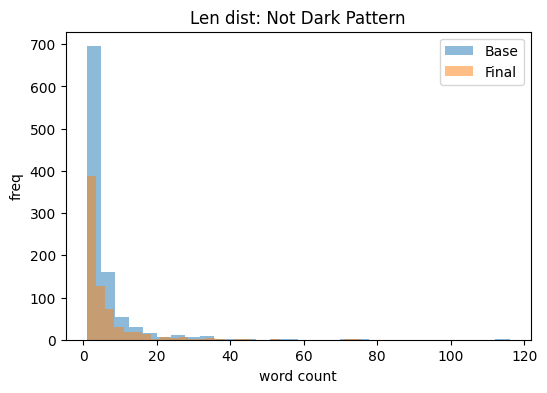

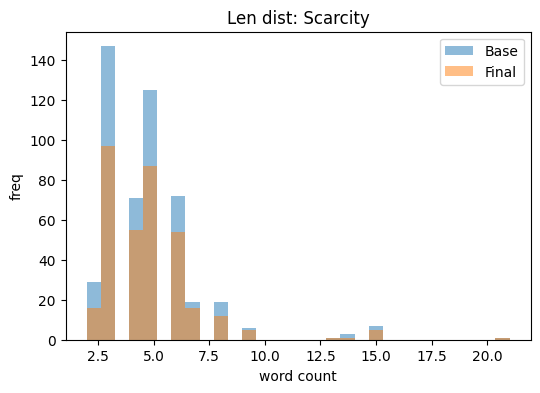

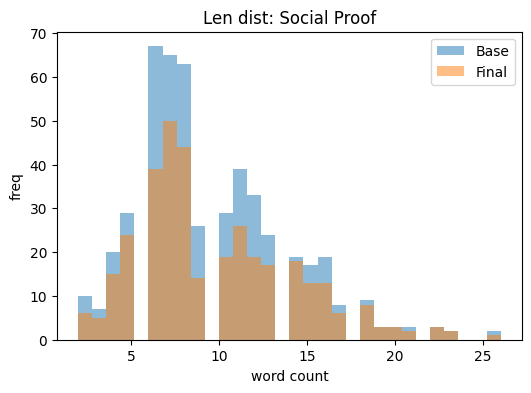

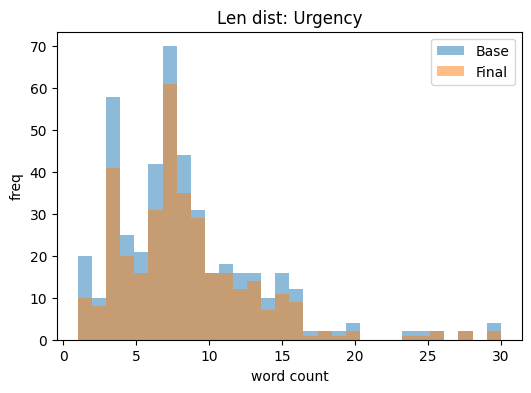

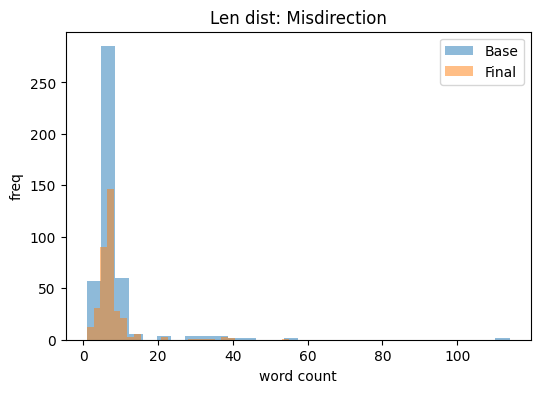

In [23]:
# ===== 검증 셀 6: 길이 분포 비교 =====
import matplotlib.pyplot as plt

def plot_len_hist(base_df, target_df, label_name, bins=30):
    b = base_df[base_df[TYPE_COL]==label_name][TEXT_COL].astype(str).str.split().str.len()
    t = target_df[target_df[TYPE_COL]==label_name][TEXT_COL].astype(str).str.split().str.len()
    plt.figure(figsize=(6,4))
    plt.hist(b, bins=bins, alpha=0.5, label='Base')
    plt.hist(t, bins=bins, alpha=0.5, label='Final')
    plt.title(f'Len dist: {label_name}')
    plt.xlabel('word count'); plt.ylabel('freq'); plt.legend(); plt.show()

# 예시: 템플릿 train에 대해 5클래스 모두 비교
target = dfs['template_train.csv']
for cls in TARGETS.keys():
    plot_len_hist(base_df, target, cls)

# 기법별 데이터 병합

In [24]:
import os
import pandas as pd

# 실제 저장된 Drive 경로
OUTPUT_DIR = "/content/drive/MyDrive/404DNF/outputs"
files_map = {
    "template": ["template_train.csv", "template_test.csv"],
    "paraphrase": ["paraphrase_train.csv", "paraphrase_test.csv"],
    "contextual": ["contextual_train.csv", "contextual_test.csv"],
}

merged_paths = {}

# 각 증강 방식별로 train/test 합치기
for key, (train_file, test_file) in files_map.items():
    train_path = os.path.join(OUTPUT_DIR, train_file)
    test_path = os.path.join(OUTPUT_DIR, test_file)

    if not (os.path.exists(train_path) and os.path.exists(test_path)):
        print(f"⚠️ {key} 파일 없음: {train_file}, {test_file}")
        continue

    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    df_merged = pd.concat([df_train, df_test], ignore_index=True)

    merged_path = os.path.join(OUTPUT_DIR, f"{key}.csv")
    df_merged.to_csv(merged_path, index=False, encoding="utf-8")
    merged_paths[key] = merged_path
    print(f"✅ {key}.csv 저장 완료 → {merged_path}")

print("\n통합된 파일들:", merged_paths)

✅ template.csv 저장 완료 → /content/drive/MyDrive/404DNF/outputs/template.csv
✅ paraphrase.csv 저장 완료 → /content/drive/MyDrive/404DNF/outputs/paraphrase.csv
✅ contextual.csv 저장 완료 → /content/drive/MyDrive/404DNF/outputs/contextual.csv

통합된 파일들: {'template': '/content/drive/MyDrive/404DNF/outputs/template.csv', 'paraphrase': '/content/drive/MyDrive/404DNF/outputs/paraphrase.csv', 'contextual': '/content/drive/MyDrive/404DNF/outputs/contextual.csv'}


In [25]:
# ===== 이미 생성된 통합 파일 검증 셀 =====
import os, pandas as pd

OUTPUT_DIR = "/content/drive/MyDrive/404DNF/outputs"
TEXT_COL, TYPE_COL, BIN_COL = "String", "Type", "label"
TARGETS = {
    "Not Dark Pattern": 1000,
    "Scarcity": 500,
    "Social Proof": 500,
    "Urgency": 500,
    "Misdirection": 500,
}

merged_files = ["template.csv", "paraphrase.csv", "contextual.csv"]

report_rows = []

for fname in merged_files:
    path = os.path.join(OUTPUT_DIR, fname)
    assert os.path.exists(path), f"{fname} 없음!"

    df = pd.read_csv(path)

    # ---- 스키마 검증 ----
    assert set([TEXT_COL, TYPE_COL, BIN_COL]).issubset(df.columns), f"{fname}: 컬럼 불일치"
    df[BIN_COL] = df[BIN_COL].astype(int)

    # ---- 클래스/라벨 분포 ----
    type_vc  = df[TYPE_COL].value_counts().reindex(TARGETS.keys(), fill_value=0)
    label_vc = df[BIN_COL].value_counts().reindex([0,1], fill_value=0)

    print(f"\n📂 {fname} (rows={len(df)})")
    print("  • 클래스 분포:", dict(type_vc))
    print("  • 라벨 분포:",   dict(label_vc))

    # 요약 테이블 행
    row = {
        "file": fname,
        "rows": len(df),
        "label_0": int(label_vc.get(0,0)),
        "label_1": int(label_vc.get(1,0)),
    }
    for k in TARGETS:
        row[f"cnt_{k}"] = int(type_vc.get(k, 0))
    report_rows.append(row)

# ---- 요약 테이블 ----
report_df = pd.DataFrame(report_rows)[
    ["file","rows","label_0","label_1",
     "cnt_Not Dark Pattern","cnt_Scarcity","cnt_Social Proof","cnt_Urgency","cnt_Misdirection"]
]
print("\n=== 통합 파일 요약 ===")
display(report_df)

# CSV 저장
report_csv = os.path.join(OUTPUT_DIR, "merged_verification_summary.csv")
report_df.to_csv(report_csv, index=False, encoding="utf-8")
print(f"\n📝 검증 요약 저장: {report_csv}")


📂 template.csv (rows=3000)
  • 클래스 분포: {'Not Dark Pattern': np.int64(1000), 'Scarcity': np.int64(500), 'Social Proof': np.int64(500), 'Urgency': np.int64(500), 'Misdirection': np.int64(500)}
  • 라벨 분포: {0: np.int64(1000), 1: np.int64(2000)}

📂 paraphrase.csv (rows=3000)
  • 클래스 분포: {'Not Dark Pattern': np.int64(1000), 'Scarcity': np.int64(500), 'Social Proof': np.int64(500), 'Urgency': np.int64(500), 'Misdirection': np.int64(500)}
  • 라벨 분포: {0: np.int64(1000), 1: np.int64(2000)}

📂 contextual.csv (rows=3000)
  • 클래스 분포: {'Not Dark Pattern': np.int64(1000), 'Scarcity': np.int64(500), 'Social Proof': np.int64(500), 'Urgency': np.int64(500), 'Misdirection': np.int64(500)}
  • 라벨 분포: {0: np.int64(1000), 1: np.int64(2000)}

=== 통합 파일 요약 ===


,file,rows,label_0,label_1,cnt_Not Dark Pattern,cnt_Scarcity,cnt_Social Proof,cnt_Urgency,cnt_Misdirection
0,template.csv,3000,1000,2000,1000,500,500,500,500
1,paraphrase.csv,3000,1000,2000,1000,500,500,500,500
2,contextual.csv,3000,1000,2000,1000,500,500,500,500



📝 검증 요약 저장: /content/drive/MyDrive/404DNF/outputs/merged_verification_summary.csv
